# Regressão 01 - tarefa 03 - transformações em X e Y

Carregue os pacotes necessários e a base de gorjetas.

### I. Modelo no valor da gorjeta

1. Crie a matriz de design (e a matriz y) utilizando o Patsy, para um modelo em ```tip```, explicada por ```sex, smoker, diner e net_bill```.  
2. Remova as variáveis não significantes.  
3. observe o gráfico de resíduos em função de ```net_bill```  
4. teste transformar ```net_bill``` no log e um polinômio. Escolha o melhor modelo.

In [31]:
import pandas as pd
import seaborn as sns
from seaborn import load_dataset
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error


%matplotlib inline

In [4]:
tips = sns.load_dataset("tips")
tips['tip_pct'] = tips['tip'] / (tips['total_bill'] - tips['tip'])
tips['net_bill'] = tips['total_bill'] - tips['tip']
tips.head(5)

,total_bill,tip,sex,smoker,day,time,size,tip_pct,net_bill
0,16.99,1.01,Female,No,Sun,Dinner,2,0.063204,15.98
1,10.34,1.66,Male,No,Sun,Dinner,3,0.191244,8.68
2,21.01,3.50,Male,No,Sun,Dinner,3,0.199886,17.51
3,23.68,3.31,Male,No,Sun,Dinner,2,0.162494,20.37
4,24.59,3.61,Female,No,Sun,Dinner,4,0.172069,20.98


In [5]:
# Visualizar os nomes das colunas (variáveis)
print(tips.columns)

Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size', 'tip_pct',
       'net_bill'],
      dtype='object')


In [6]:
# Criando uma variável dummy para representar a condição time == 'Dinner'
tips['Dinner_dummy'] = (tips['time'] == 'Dinner').astype(int)

# Criando a matriz de design e a matriz y usando Patsy
formula = 'tip ~ sex + smoker + Dinner_dummy + net_bill'
y, X = patsy.dmatrices(formula, data=tips, return_type='dataframe')

# Visualizar as matrizes
print("Matriz y:")
print(y.head())

print("\nMatriz de design:")
print(X.head())

Matriz y:
    tip
0  1.01
1  1.66
2  3.50
3  3.31
4  3.61

Matriz de design:
   Intercept  sex[T.Female]  smoker[T.No]  Dinner_dummy  net_bill
0        1.0            1.0           1.0           1.0     15.98
1        1.0            0.0           1.0           1.0      8.68
2        1.0            0.0           1.0           1.0     17.51
3        1.0            0.0           1.0           1.0     20.37
4        1.0            1.0           1.0           1.0     20.98


In [7]:
model = sm.OLS(y, X).fit()

# Exibição do resumo do modelo
print(model.summary())

# Removendo de variáveis não significativas, excluindo o intercepto
non_significant_vars = []
for var in model.pvalues.index:
    if var != 'Intercept' and model.pvalues[var] > 0.05:
        non_significant_vars.append(var)

# Exibição das variáveis não significativas
print("Variáveis não significativas:", non_significant_vars)

# Removendo das variáveis não significativas do DataFrame X
X = X.drop(columns=non_significant_vars)

# Ajustando do novo modelo
new_model = sm.OLS(y, X).fit()

# Exibindo o resumo do novo modelo
print(new_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    tip   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     30.13
Date:                Sun, 28 Jan 2024   Prob (F-statistic):           2.64e-20
Time:                        12:11:00   Log-Likelihood:                -375.13
No. Observations:                 244   AIC:                             760.3
Df Residuals:                     239   BIC:                             777.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1999      0.242      4.952

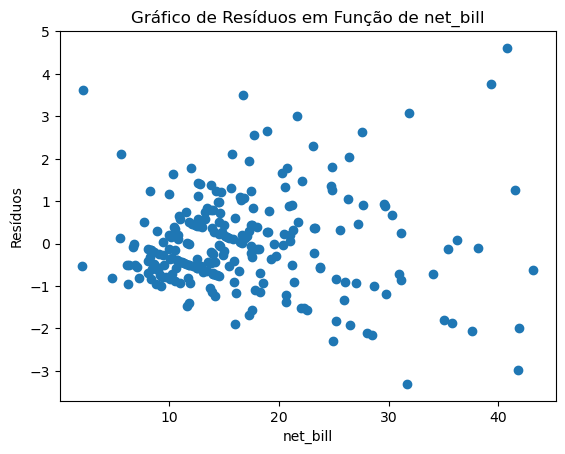

In [8]:
residuals = new_model.resid

# Gráfico de dispersão dos resíduos em função de net_bill
plt.scatter(X['net_bill'], residuals)
plt.title('Gráfico de Resíduos em Função de net_bill')
plt.xlabel('net_bill')
plt.ylabel('Resíduos')
plt.show()

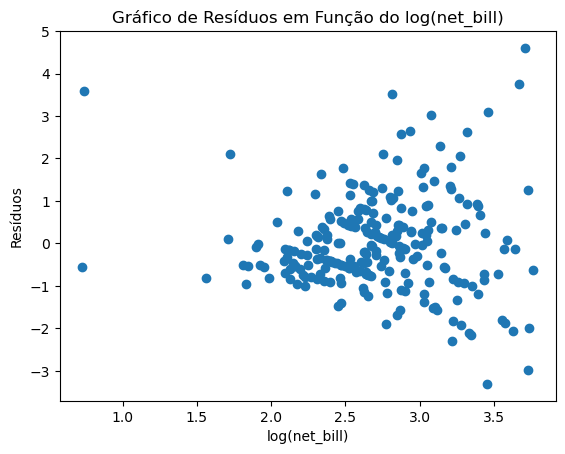

In [9]:
# Adicionando a transformação logarítmica a net_bill
X['net_bill_log'] = np.log(X['net_bill'])

# Ajustando o modelo com a nova variável transformada
model_log = sm.OLS(y, X).fit()

# Gráfico de dispersão dos resíduos em função do log(net_bill)
residuals_log = model_log.resid
plt.scatter(X['net_bill_log'], residuals_log)
plt.title('Gráfico de Resíduos em Função do log(net_bill)')
plt.xlabel('log(net_bill)')
plt.ylabel('Resíduos')
plt.show()

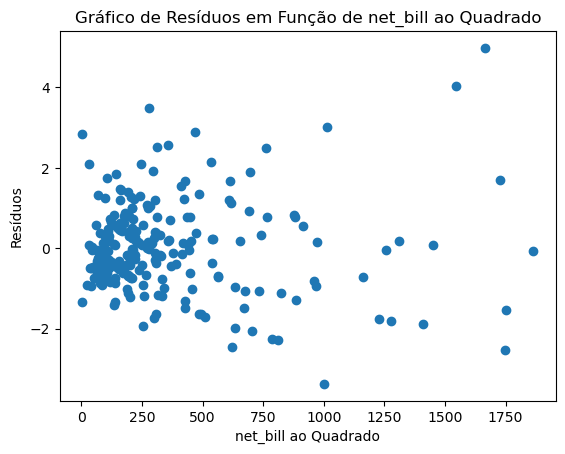

In [10]:
# Adicionando a transformação polinomial a net_bill (de grau 2)
X['net_bill_poly'] = X['net_bill']**2

# Ajuste do modelo com a nova variável transformada
model_poly = sm.OLS(y, X).fit()

# Gráfico de dispersão dos resíduos em função do net_bill ao quadrado
residuals_poly = model_poly.resid
plt.scatter(X['net_bill_poly'], residuals_poly)
plt.title('Gráfico de Resíduos em Função de net_bill ao Quadrado')
plt.xlabel('net_bill ao Quadrado')
plt.ylabel('Resíduos')
plt.show()

A partir do exame dos gráficos de resíduos verifica-se que o gráfico de Resíduos em Função do log(net_bill) é mais constante em todos os níveis das variáveis.

### II. Modelo no valor do percentual da gorjeta

1. Crie a matriz de design (e a matriz y) utilizando o Patsy, para um modelo no log de ```tip```, explicado por ```sex, smoker, diner e net_bill```.
2. Remova as variáveis não significantes.
3. Observe o gráfico de resíduos em função de ```net_bill```
4. Teste transformar ```net_bill``` no log e um polinômio. Escolha o melhor modelo.
5. Do modelo final deste item, calcule o $R^2$ na escala de ```tip``` (sem o log). Compare com o modelo do item 1. Qual tem melhor coeficiente de determinação?

In [11]:
# Criando uma variável dummy para representar a condição time == 'Dinner'
tips['Dinner_dummy'] = (tips['time'] == 'Dinner').astype(int)

# Criando a matriz de design e a matriz y usando Patsy
formula = 'tip ~ sex + smoker + Dinner_dummy + net_bill'
y, X = patsy.dmatrices(formula, data=tips, return_type='dataframe')

# Visualizar as matrizes
print("Matriz y:")
print(y.head())

print("\nMatriz de design:")
print(X.head())

Matriz y:
    tip
0  1.01
1  1.66
2  3.50
3  3.31
4  3.61

Matriz de design:
   Intercept  sex[T.Female]  smoker[T.No]  Dinner_dummy  net_bill
0        1.0            1.0           1.0           1.0     15.98
1        1.0            0.0           1.0           1.0      8.68
2        1.0            0.0           1.0           1.0     17.51
3        1.0            0.0           1.0           1.0     20.37
4        1.0            1.0           1.0           1.0     20.98


In [12]:
model = sm.OLS(y, X).fit()

# Exibição do resumo do modelo
print(model.summary())

# Removendo de variáveis não significativas, excluindo o intercepto
non_significant_vars = []
for var in model.pvalues.index:
    if var != 'Intercept' and model.pvalues[var] > 0.05:
        non_significant_vars.append(var)

# Exibição das variáveis não significativas
print("Variáveis não significativas:", non_significant_vars)

# Removendo das variáveis não significativas do DataFrame X
X = X.drop(columns=non_significant_vars)

# Ajustando do novo modelo
new_model = sm.OLS(y, X).fit()

# Exibindo o resumo do novo modelo
print(new_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    tip   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     30.13
Date:                Sun, 28 Jan 2024   Prob (F-statistic):           2.64e-20
Time:                        12:11:07   Log-Likelihood:                -375.13
No. Observations:                 244   AIC:                             760.3
Df Residuals:                     239   BIC:                             777.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1999      0.242      4.952

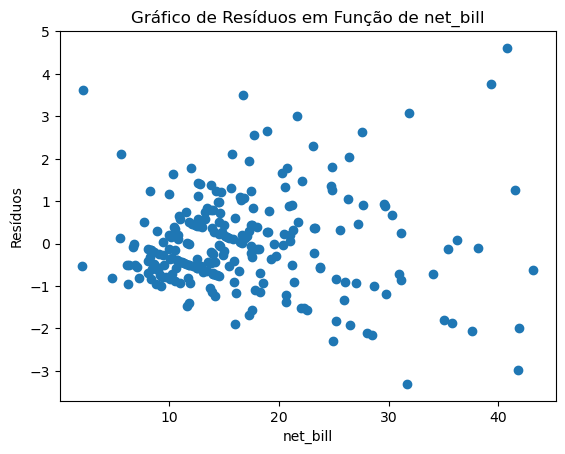

In [13]:
residuals = new_model.resid

# Gráfico de dispersão dos resíduos em função de net_bill
plt.scatter(X['net_bill'], residuals)
plt.title('Gráfico de Resíduos em Função de net_bill')
plt.xlabel('net_bill')
plt.ylabel('Resíduos')
plt.show()

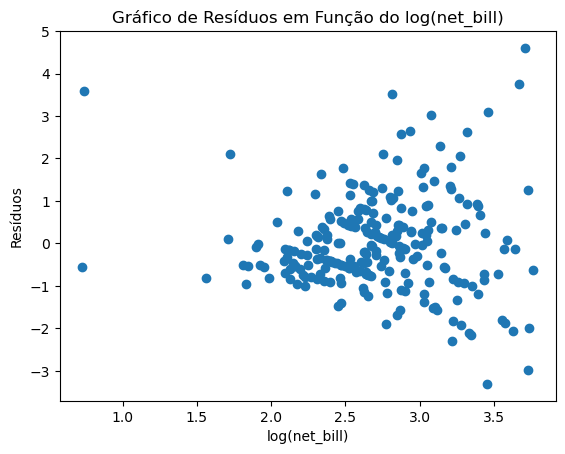

In [14]:
# Adicionando a transformação logarítmica a net_bill
X['net_bill_log'] = np.log(X['net_bill'])

# Ajustando o modelo com a nova variável transformada
model_log = sm.OLS(y, X).fit()

# Gráfico de dispersão dos resíduos em função do log(net_bill)
residuals_log = model_log.resid
plt.scatter(X['net_bill_log'], residuals_log)
plt.title('Gráfico de Resíduos em Função do log(net_bill)')
plt.xlabel('log(net_bill)')
plt.ylabel('Resíduos')
plt.show()

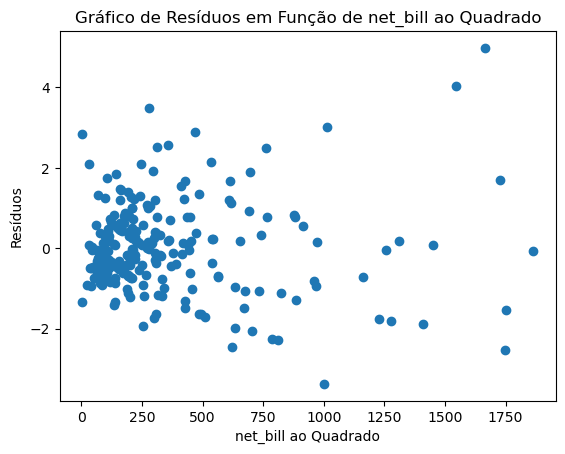

In [15]:
# Adicionando a transformação polinomial a net_bill (de grau 2)
X['net_bill_poly'] = X['net_bill']**2

# Ajuste do modelo com a nova variável transformada
model_poly = sm.OLS(y, X).fit()

# Gráfico de dispersão dos resíduos em função do net_bill ao quadrado
residuals_poly = model_poly.resid
plt.scatter(X['net_bill_poly'], residuals_poly)
plt.title('Gráfico de Resíduos em Função de net_bill ao Quadrado')
plt.xlabel('net_bill ao Quadrado')
plt.ylabel('Resíduos')
plt.show()

A partir do exame dos gráficos de resíduos verifica-se que o gráfico de Resíduos em Função do log(net_bill) é mais constante em todos os níveis das variáveis.

In [16]:
y_pred_poly = model_poly.predict(X)  # Previsões do modelo com a transformação polinomial
y_actual = y  # Valores reais da variável de resposta 'tip'

# Soma dos Quadrados dos Resíduos
ss_residual_poly = np.sum((y_actual - y_pred_poly)**2)

# Soma Total dos Quadrados
ss_total = np.sum((y_actual - np.mean(y_actual))**2)

# Coeficiente de Determinação R^2
r_squared_tip_poly = 1 - (ss_residual_poly / ss_total)

print("R-squared para o modelo final com a transformação polinomial na escala de tip:", r_squared_tip_poly)

R-squared para o modelo final com a transformação polinomial na escala de tip: 0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
240    NaN
241    NaN
242    NaN
243    NaN
tip    1.0
Length: 245, dtype: float64


In [17]:
O modelo do ítem 1 apresenta melhor coeficiente de determinação

SyntaxError: invalid syntax (1469417773.py, line 1)

### III. Previsão de renda

Vamos trabalhar a base que você vai usar no projeto do final deste ciclo.

Carregue a base ```previsao_de_renda.csv```.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

1. Ajuste um modelo de regressão linear simples para explicar ```renda``` como variável resposta, por ```tempo_emprego``` como variável explicativa. Observe que há muitas observações nessa tabela. Utilize os recursos que achar necessário.
2. Faça uma análise de resíduos. Com os recursos vistos neste módulo, como você melhoraria esta regressão?
3. Ajuste um modelo de regressão linear múltipla para explicar ```renda``` (ou uma transformação de ```renda```) de acordo com as demais variáveis.
4. Remova as variáveis não significantes e ajuste novamente o modelo. Interprete os parâmetros
5. Faça uma análise de resíduos. Avalie a qualidade do ajuste.

In [19]:
df = pd.read_csv('previsao_de_renda.csv')

In [20]:
df.head()

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


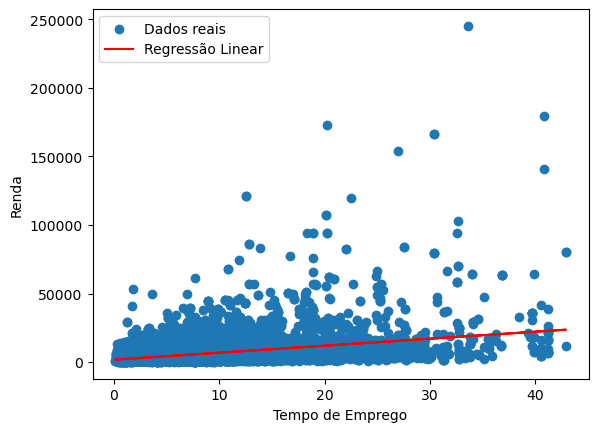

In [22]:
# Extraindo as variáveis de interesse
X = df['tempo_emprego'].values.reshape(-1, 1)  # Variável explicativa
y = df['renda'].values  # Variável resposta

# Tratando valores ausentes
imputer = SimpleImputer(strategy='mean')  
X = imputer.fit_transform(X)

# Inicializando e treinar o modelo de regressão linear
modelo_regressao_linear = LinearRegression()
modelo_regressao_linear.fit(X, y)

# Fazendo previsões usando o modelo treinado
previsoes_renda = modelo_regressao_linear.predict(X)

# Plotando os dados e a linha de regressão
plt.scatter(X, y, label='Dados reais')
plt.plot(X, previsoes_renda, color='red', label='Regressão Linear')
plt.xlabel('Tempo de Emprego')
plt.ylabel('Renda')
plt.legend()
plt.show()

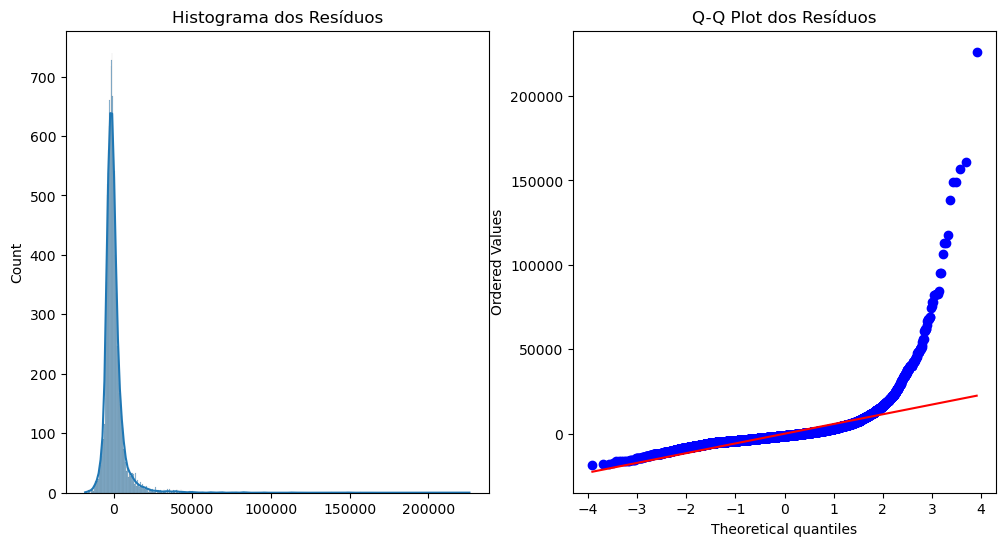

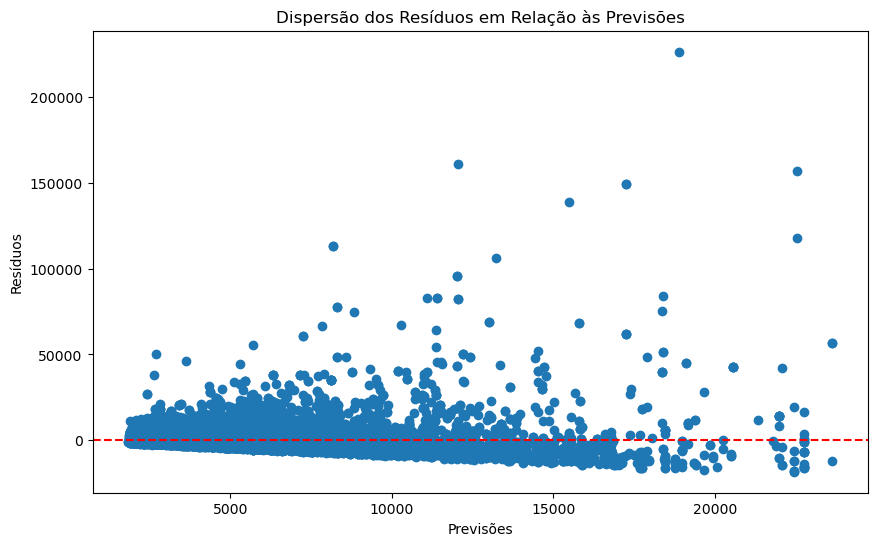

In [25]:
# Calculando os resíduos
residuos = y - previsoes_renda

# Verificando a normalidade dos resíduos
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuos, kde=True)
plt.title('Histograma dos Resíduos')

plt.subplot(1, 2, 2)
stats.probplot(residuos, plot=plt)
plt.title('Q-Q Plot dos Resíduos')

plt.show()

# Analisando a dispersão de resíduos
plt.figure(figsize=(10, 6))
plt.scatter(previsoes_renda, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Dispersão dos Resíduos em Relação às Previsões')
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()

Para melhorar essa regressão eu poderia usar a técnicas de transformações logarítmicas e também normalizar ou padronizar as variáveis para garantir que todas estejam na mesma escala, conforme realizado.

In [25]:
# Separando as variáveis numéricas e categóricas
numeric_features = df.select_dtypes(include=['number']).drop('renda', axis=1).columns
categorical_features = df.select_dtypes(include=['object']).columns

# Definindo variáveis de entrada (X) e saída (y)
X = df.drop('renda', axis=1)
y = df['renda']

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando transformadores para variáveis numéricas e categóricas
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Criando o preprocessor 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Criando o pipeline com o preprocessor e o modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Treinando o modelo 
pipeline.fit(X_train, y_train)

# Fazendo previsões usando o modelo treinado
y_pred = pipeline.predict(X_test)

# Calculando o MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 34666010.14141152


In [28]:
# Criando o pipeline com o preprocessor e o modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(LinearRegression(), n_features_to_select=5)),  # Selecionar 5 melhores características
    ('regressor', LinearRegression())
])

# Treinando o modelo 
pipeline.fit(X_train, y_train)

# Fazendo previsões usando o modelo treinado
y_pred = pipeline.predict(X_test)

# Calculando o MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 44126019.59734839


Houve um aumento significativo no MSE, o que significa que os erros entre os valores preditos pelo modelo e os valores reais também estão aumentando. Em outras palavras, o modelo está tendo um desempenho pior em termos de precisão de previsão.

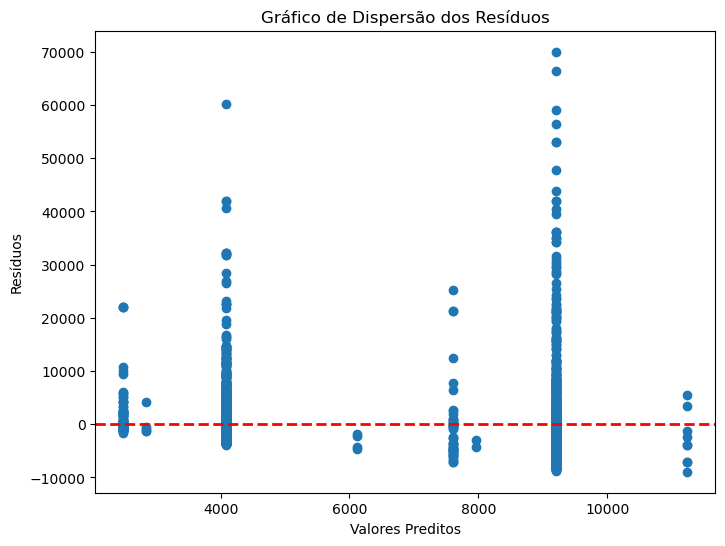

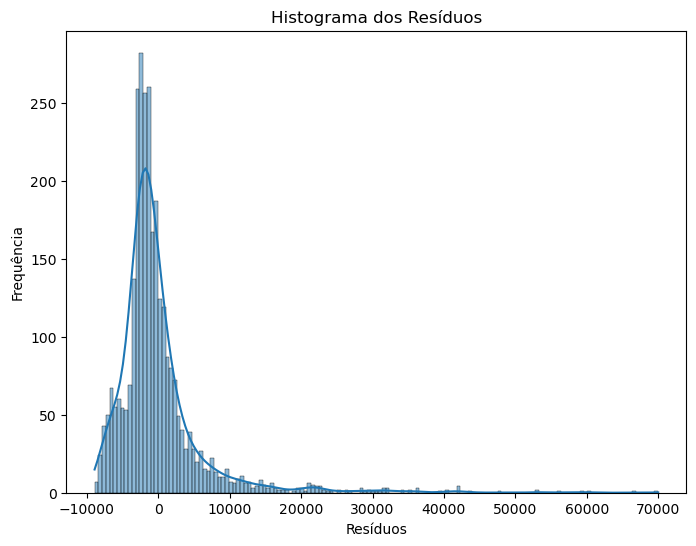

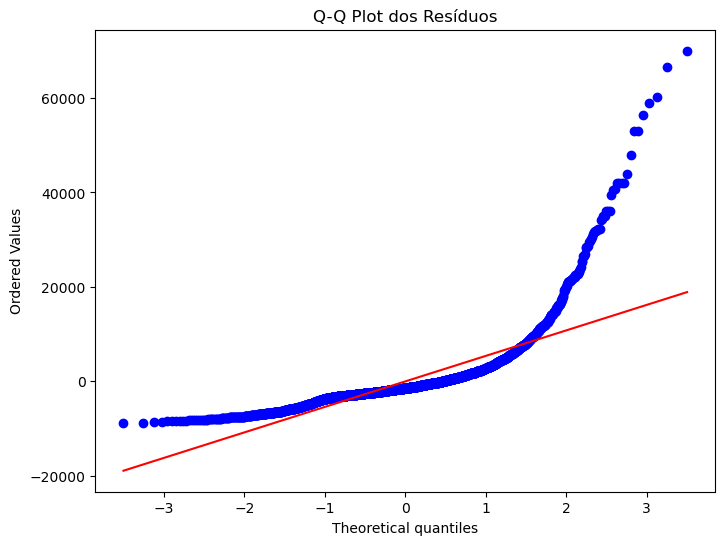

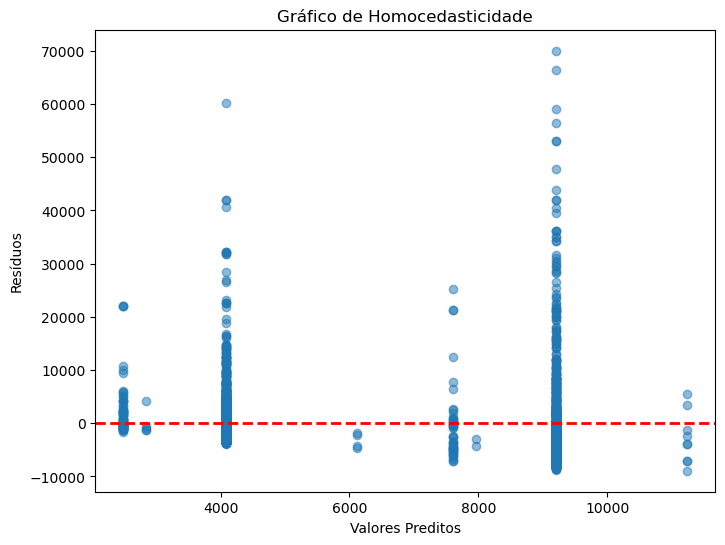

Mean Squared Error (MSE): 44126019.59734839
R2 Score: 0.09947065101964969


In [32]:
# Calculando resíduos
residuos = y_test - y_pred

# Gráfico de dispersão dos resíduos
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuos)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Gráfico de Dispersão dos Resíduos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.show()

# Histograma dos resíduos
plt.figure(figsize=(8, 6))
sns.histplot(residuos, kde=True)
plt.title('Histograma dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

# Q-Q plot dos resíduos
plt.figure(figsize=(8, 6))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Q-Q Plot dos Resíduos')
plt.show()

# Gráfico de resíduos
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Gráfico de Homocedasticidade')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.show()

# Métricas adicionais
print(f'Mean Squared Error (MSE): {metrics.mean_squared_error(y_test, y_pred)}')
print(f'R2 Score: {metrics.r2_score(y_test, y_pred)}')

Através da Análise de Resíduos e R2 score que o ajuste não trouxe melhorias ao modelo.